In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.ensemble import VotingClassifier


from sklearn.svm import SVC

import shap

from sklearn.model_selection import cross_val_score

np.random.seed(42)

# import sklearn
sklearn.__version__

In [2]:
shap.initjs()

catboost ritorna le sue predizioni come interi, in questo  modo le predizioni verranno castate ad int (usato solo in fase di voting)

In [3]:
class CatBoostClassifierCorrected(CatBoostClassifier):
    def fit(self, X, y=None, cat_features=None, sample_weight=None, baseline=None, use_best_model=None,
        eval_set=None, verbose=None, logging_level=None, plot=False, column_description=None, verbose_eval=None):

        self.le_ = LabelEncoder().fit(y)
        transformed_y = self.le_.transform(y)

        self._fit(X, transformed_y, cat_features, None, sample_weight, None, None, None, baseline, use_best_model, eval_set, verbose, logging_level, plot, column_description, verbose_eval)
        return self

    def predict(self, data, prediction_type='Class', ntree_start=0, ntree_end=0, thread_count=1, verbose=None):
        predictions = self._predict(data, prediction_type, ntree_start, ntree_end, thread_count, verbose)

        # This line is the only change I did
        return self.le_.inverse_transform(predictions.astype(np.int64))

# Autism Screening

## Dataset Utilizzati

- https://archive.ics.uci.edu/ml/datasets/Autism+Screening+Adult

- https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++

Note: i due dataset fanno riferimento allo stesso studio ma si differenziano per l'età dei partecipanti.

I due datast sono stati convertiti dal formato `.arff` al formato `.csv` usando [questa libreria](https://github.com/Hutdris/arff2csv)

# Analisi dei dati

All'interno di queta sezione verranno analizzati i dati scaricati dal database UCI, verra' preso in considerazione il dataset composto dall'unione dei due specifici

In [4]:
child = pd.read_csv('Autism-Child-Data.csv')
adult = pd.read_csv('Autism-Adult-Data.csv')
complete = pd.concat([child, adult])

## Analisi delle feature

Per prima cosa viene effettuata una analisi delle feature presenti nel dataset

In [5]:
complete.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [6]:
child.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [7]:
adult.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [8]:
complete.sample(5)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
540,1,1,1,1,1,1,0,1,1,1,...,m,White-European,no,no,'United States',no,9,'18 and more',Relative,YES
678,1,1,1,1,1,0,0,1,1,1,...,f,Black,no,no,'United States',no,8,'18 and more',Self,YES
96,1,1,1,1,1,1,0,1,0,1,...,m,White-European,no,no,Sweden,no,8,'4-11 years',Parent,YES
295,1,0,1,1,1,1,0,0,1,1,...,f,White-European,no,no,Canada,no,7,'18 and more',Self,YES
158,1,0,0,1,0,0,0,0,1,1,...,f,Asian,no,no,India,no,4,'18 and more',Self,NO


- A*_Score -> indica la risposta data ad una domanda del test, una feature per ogni domanda del test
    contiene un valore booleano che indica se la risposta fornita è stat positiva o negativa.
- age -> eta' del soggetto
- gender -> sesso del soggetto
- ethnicity -> etnia del soggetto
- jundice -> presenza di itterizia alla nascita (condizione molto comune negli USA, il neonato presenta una colorazione gialla/verde della pelle, della sclera e delle mucose a cuasa di un innalzamento dei livelli di Bilirubina nel sangue)
- autism -> indica se un parente diretto e' stato diagnosticato PDD (_Pervasive developemental distorder_, uno dei tipi dello spettro autistico, definito dal DSM-IV come "severo e pervasimo impedimento nello sviluppo delle relazioni interpersonali o nella comunicazione verbale e non verbale")
- country_of_res -> paese di residenza
- used_app_before -> indica se il test era stato eseguito in precedenza
- result -> numero di risposte affermative date
- age_desc -> età discretizzata in infante e adulto
- relation -> relazione che intercorre tra il soggetto e il somministratore del test
- cass/ASD -> diagnosi, __classe da predire__

## Pulizia dei dati

Dopo avere definito i dati con cui si sta lavorando si procede con la pulizia, iniziando rimuovendo eventuali duplicati

In [9]:
print(complete.shape)
complete = complete.drop_duplicates(keep = 'first')
print(complete.shape)

(996, 21)
(989, 21)


Dopo avere rimosso i duplicati si procede con una analisi per determinare la presenza di eventuali valori nulli

In [10]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 989 entries, 0 to 703
Data columns (total 21 columns):
A1_Score           989 non-null int64
A2_Score           989 non-null int64
A3_Score           989 non-null int64
A4_Score           989 non-null int64
A5_Score           989 non-null int64
A6_Score           989 non-null int64
A7_Score           989 non-null int64
A8_Score           989 non-null int64
A9_Score           989 non-null int64
A10_Score          989 non-null int64
age                989 non-null object
gender             989 non-null object
ethnicity          989 non-null object
jundice            989 non-null object
austim             989 non-null object
contry_of_res      989 non-null object
used_app_before    989 non-null object
result             989 non-null int64
age_desc           989 non-null object
relation           989 non-null object
Class/ASD          989 non-null object
dtypes: int64(11), object(10)
memory usage: 170.0+ KB


I tipi dei dati sono:

In [11]:
complete.dtypes

A1_Score            int64
A2_Score            int64
A3_Score            int64
A4_Score            int64
A5_Score            int64
A6_Score            int64
A7_Score            int64
A8_Score            int64
A9_Score            int64
A10_Score           int64
age                object
gender             object
ethnicity          object
jundice            object
austim             object
contry_of_res      object
used_app_before    object
result              int64
age_desc           object
relation           object
Class/ASD          object
dtype: object

dato che le colonne dele risposte dei semplici valori binari è possibile convertire gli `int64` in `int8`

In [12]:
for question in complete.columns[0:10]:
    child[question] = child[question].astype('int8')
    adult[question] = adult[question].astype('int8')
    complete[question] = complete[question].astype('int8')

Lo stesso discorso vale per `result`, essendo il numero delle risposte positive date è necessario un `int8` per memorizzare tutti i posisbili valori

In [13]:
child['result'] = child['result'].astype('int8')
adult['result'] = adult['result'].astype('int8')
complete['result'] = complete['result'].astype('int8')

E' possibile notare come l'età venga erroneamente riconosciuta come stringa, per ovviare al problema si esegue un cast esplicito.
Prima di procedere con il cast è necessario sostituire i valori contrassegnati con `?` devono essere posti a `nan`, come sostituzione si userà la media (per dataset, non globale)

In [14]:
child['age'] = child['age'].replace('?', np.nan)
adult['age'] = adult['age'].replace('?', np.nan)

child['age'] = pd.to_numeric(child['age'], downcast = 'integer')
adult['age'] = pd.to_numeric(adult['age'], downcast = 'integer')

child['age'] = child['age'].fillna(child['age'].mean())
adult['age'] = adult['age'].fillna(adult['age'].mean())

child['age'] = child['age'].astype('int8')
adult['age'] = adult['age'].astype('int8')


complete = pd.concat([child, adult])

In [15]:
complete.dtypes

A1_Score             int8
A2_Score             int8
A3_Score             int8
A4_Score             int8
A5_Score             int8
A6_Score             int8
A7_Score             int8
A8_Score             int8
A9_Score             int8
A10_Score            int8
age                  int8
gender             object
ethnicity          object
jundice            object
austim             object
contry_of_res      object
used_app_before    object
result               int8
age_desc           object
relation           object
Class/ASD          object
dtype: object

Visto l'alto numero di parametri di tipo categorico `catboost` è un ottimo modello candidato dato che è stato pensato appoistamente per questo tipo di dati.
Per usare modelli che non gestiscono in modo nativo feature categoriche sarà necessario usare metodi come `one hot encoding` per convertire le stringhe in numeri

Visto l'alto numero di parametri di tipo categorico `catboost` è un ottimo modello candidato dato che è stato pensato appoistamente per questo tipo di dati.
Per usare modelli che non gestiscono in modo nativo feature categoriche sarà necessario usare metodi come `one hot encoding` per convertire le stringhe in numeri.

Probabilmente anche le altre feature categoriche presentano valori nulli ma si decide di non intervenire in modo da dare la possibilità ai modelli scelti di intervnire in modo autonomo. Questo è reso possibile anche dal datto che i modellis scelti permettono di gestire in modo nativo i valori mancanti.

In [16]:
complete.sample(10)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
400,1,0,0,1,0,0,1,1,0,1,...,f,?,no,no,'United Arab Emirates',no,5,'18 and more',?,NO
694,1,1,1,1,1,0,0,1,0,1,...,m,White-European,yes,no,'United States',no,7,'18 and more',Self,YES
260,0,0,0,0,0,0,1,1,0,1,...,m,Asian,no,no,India,no,3,'18 and more',Self,NO
304,1,1,1,1,1,0,0,0,1,0,...,m,Asian,no,no,Afghanistan,no,6,'18 and more',Self,NO
95,1,1,0,0,0,0,0,1,0,1,...,f,White-European,no,no,'United Kingdom',no,4,'18 and more',Self,NO
657,1,1,0,0,1,0,1,0,1,0,...,m,others,no,no,'United States',no,5,'18 and more',Self,NO
378,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,'United Arab Emirates',no,2,'18 and more',?,NO
76,1,0,0,0,0,0,1,1,0,0,...,m,'Middle Eastern ',no,no,'United States',no,3,'18 and more',Self,NO
97,1,0,0,1,1,0,1,0,0,0,...,m,Others,no,no,'New Zealand',no,4,'18 and more',Self,NO
278,1,0,0,0,1,0,0,1,0,1,...,f,White-European,no,no,'United Kingdom',no,4,'4-11 years',Parent,NO


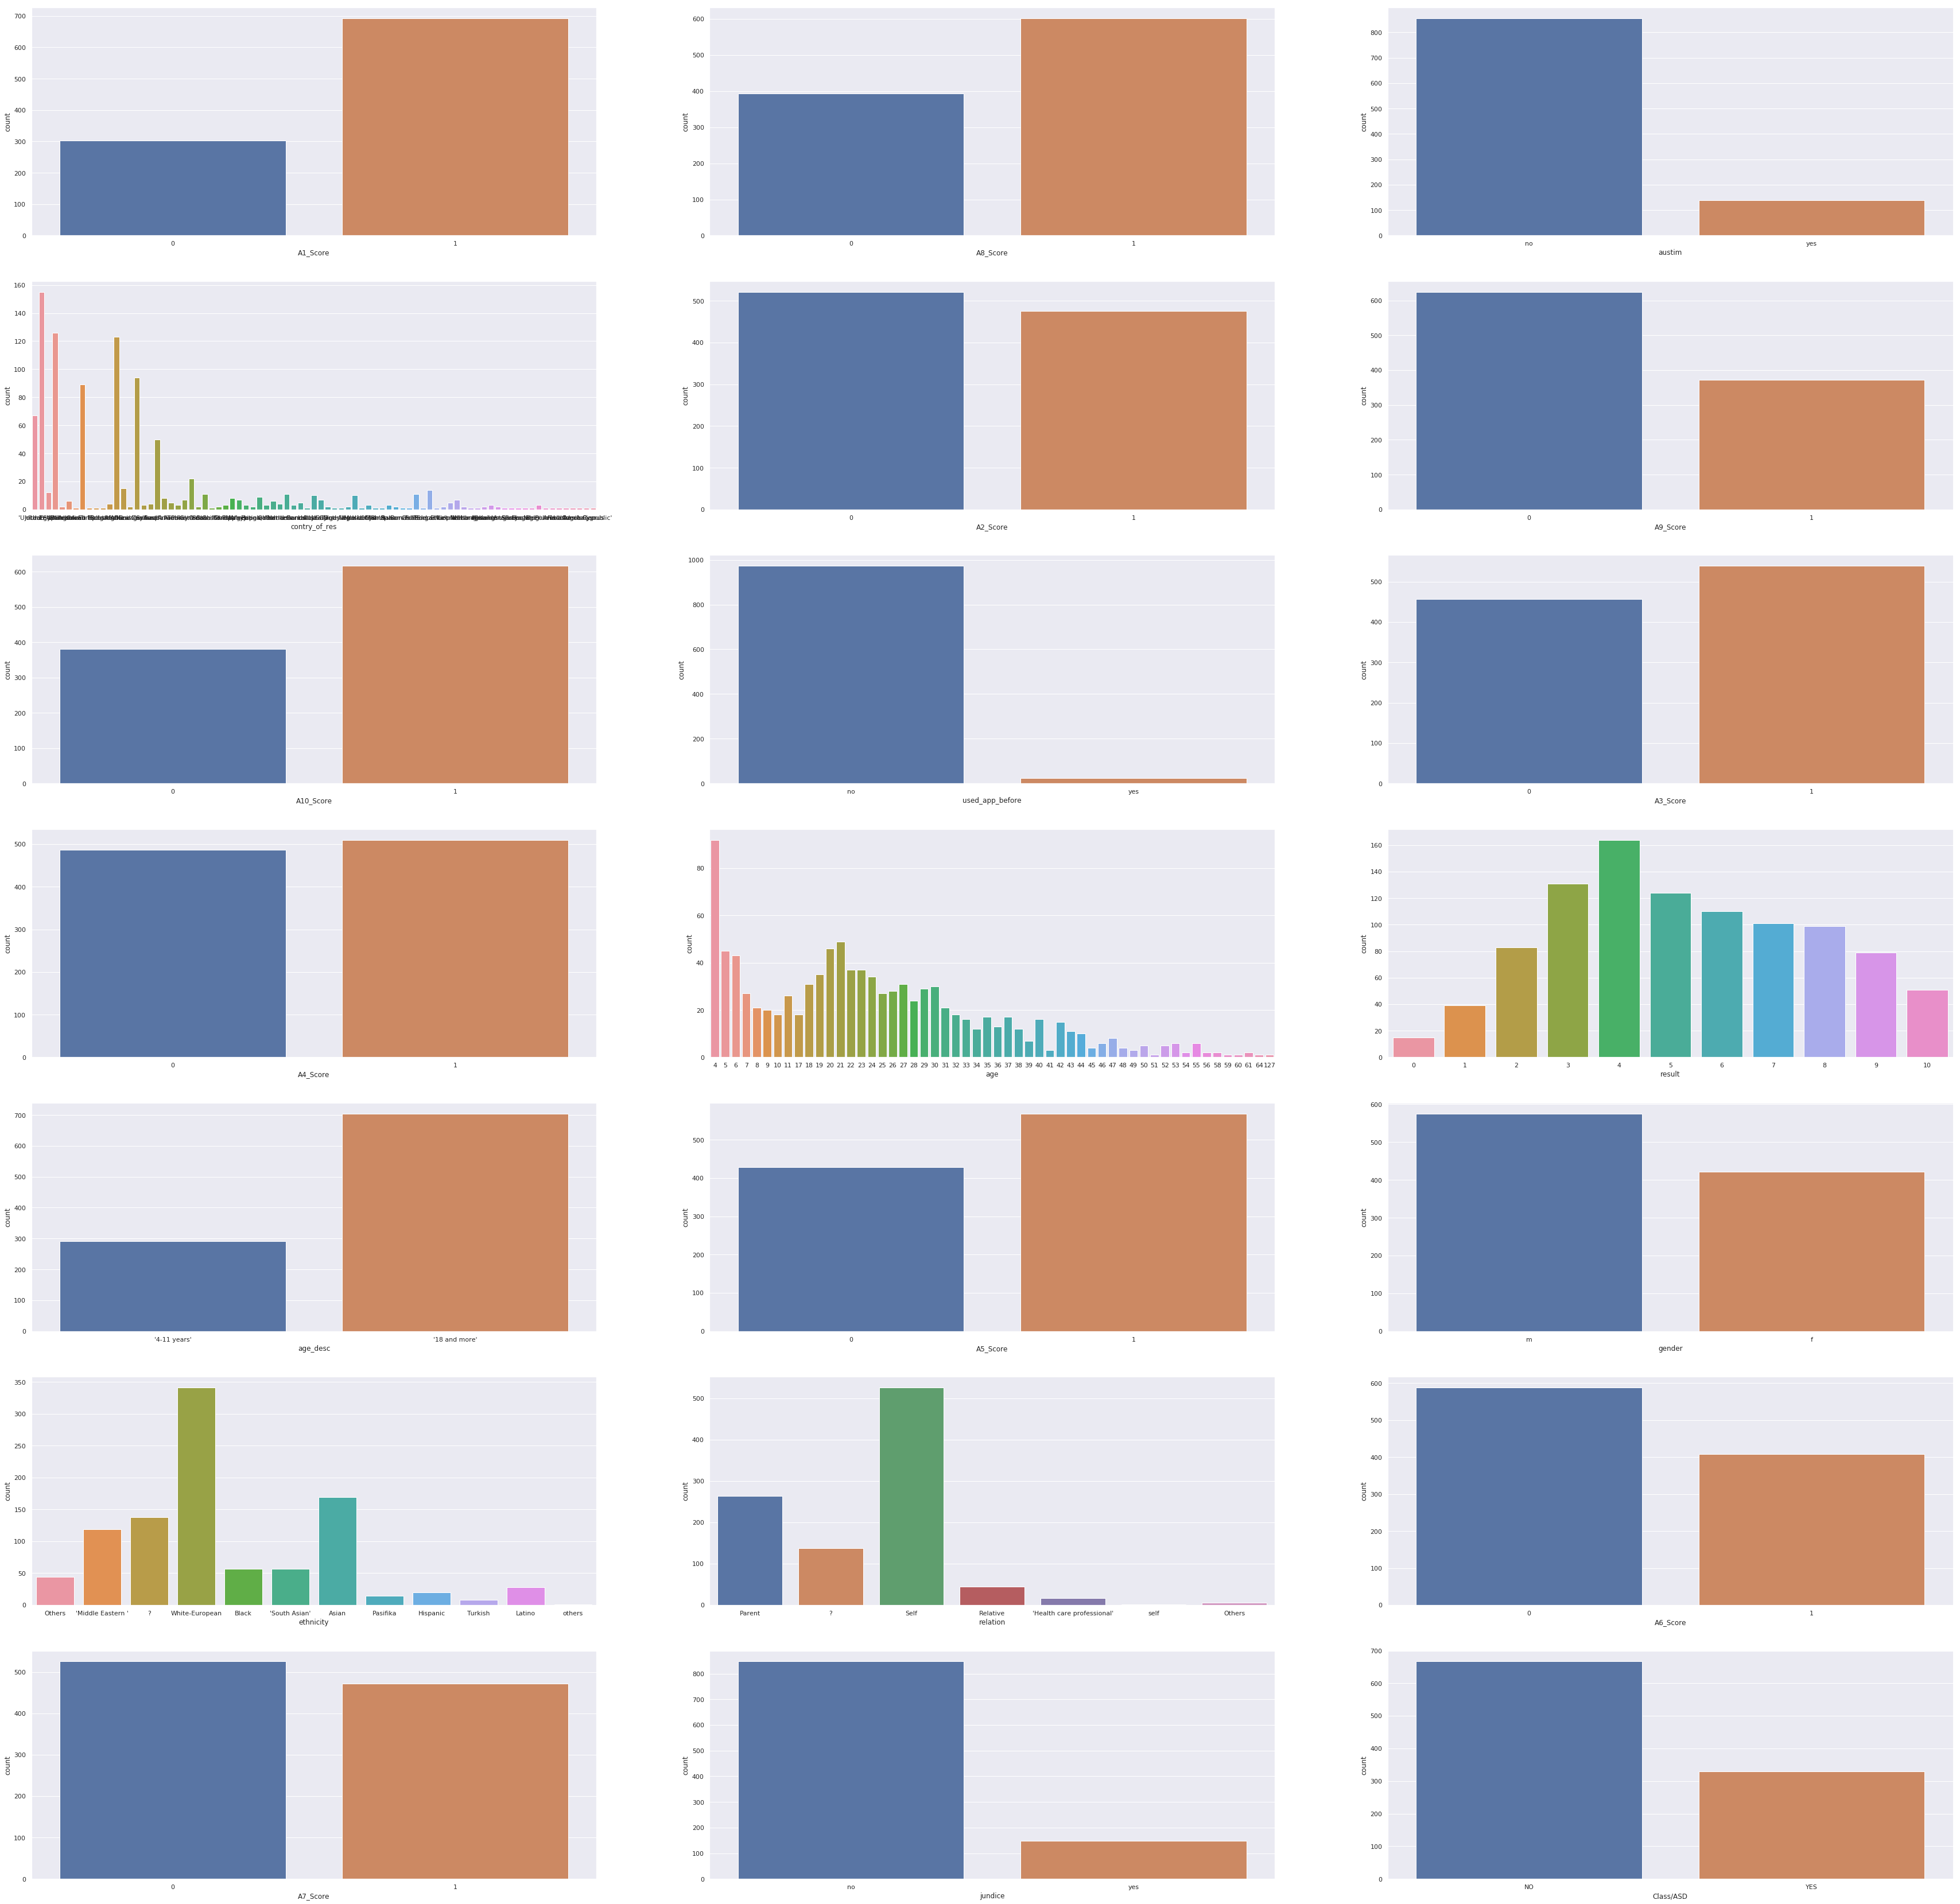

In [17]:
fig, axarr = plt.subplots(7, 3, figsize = (60, 60))


for i, column in enumerate(complete.columns):
    plt.sca(axarr[i % 7, i % 3])
    sns.countplot(x = column, data = complete)

plt.show()

Osservano i grafici è anche possibile notare che per le feature `relation` e `ethnics` è presente sia l'attributo `self` che l'attributo `Self`, pertanto occorre convertire tutto nello stesso case 

In [18]:
complete['relation']  = complete['relation'].str.lower()
child['relation']  = child['relation'].str.lower()
adult['relation']  = adult['relation'].str.lower()

complete['ethnicity']  = complete['ethnicity'].str.lower()
child['ethnicity']  = child['ethnicity'].str.lower()
adult['ethnicity']  = adult['ethnicity'].str.lower()

Osservando i grafici è possibile osservare un forte imbilanciamento tra le due classi, quando si procederà con la divisione in train e test set occorrerà assicurarsi di procedere con una divisione stratificata dei sample per fare in modo che questa proporzione sia mantenuta e impostare il modello in modo che penalizzi maggiormente errori per la classe con meno esponenti.

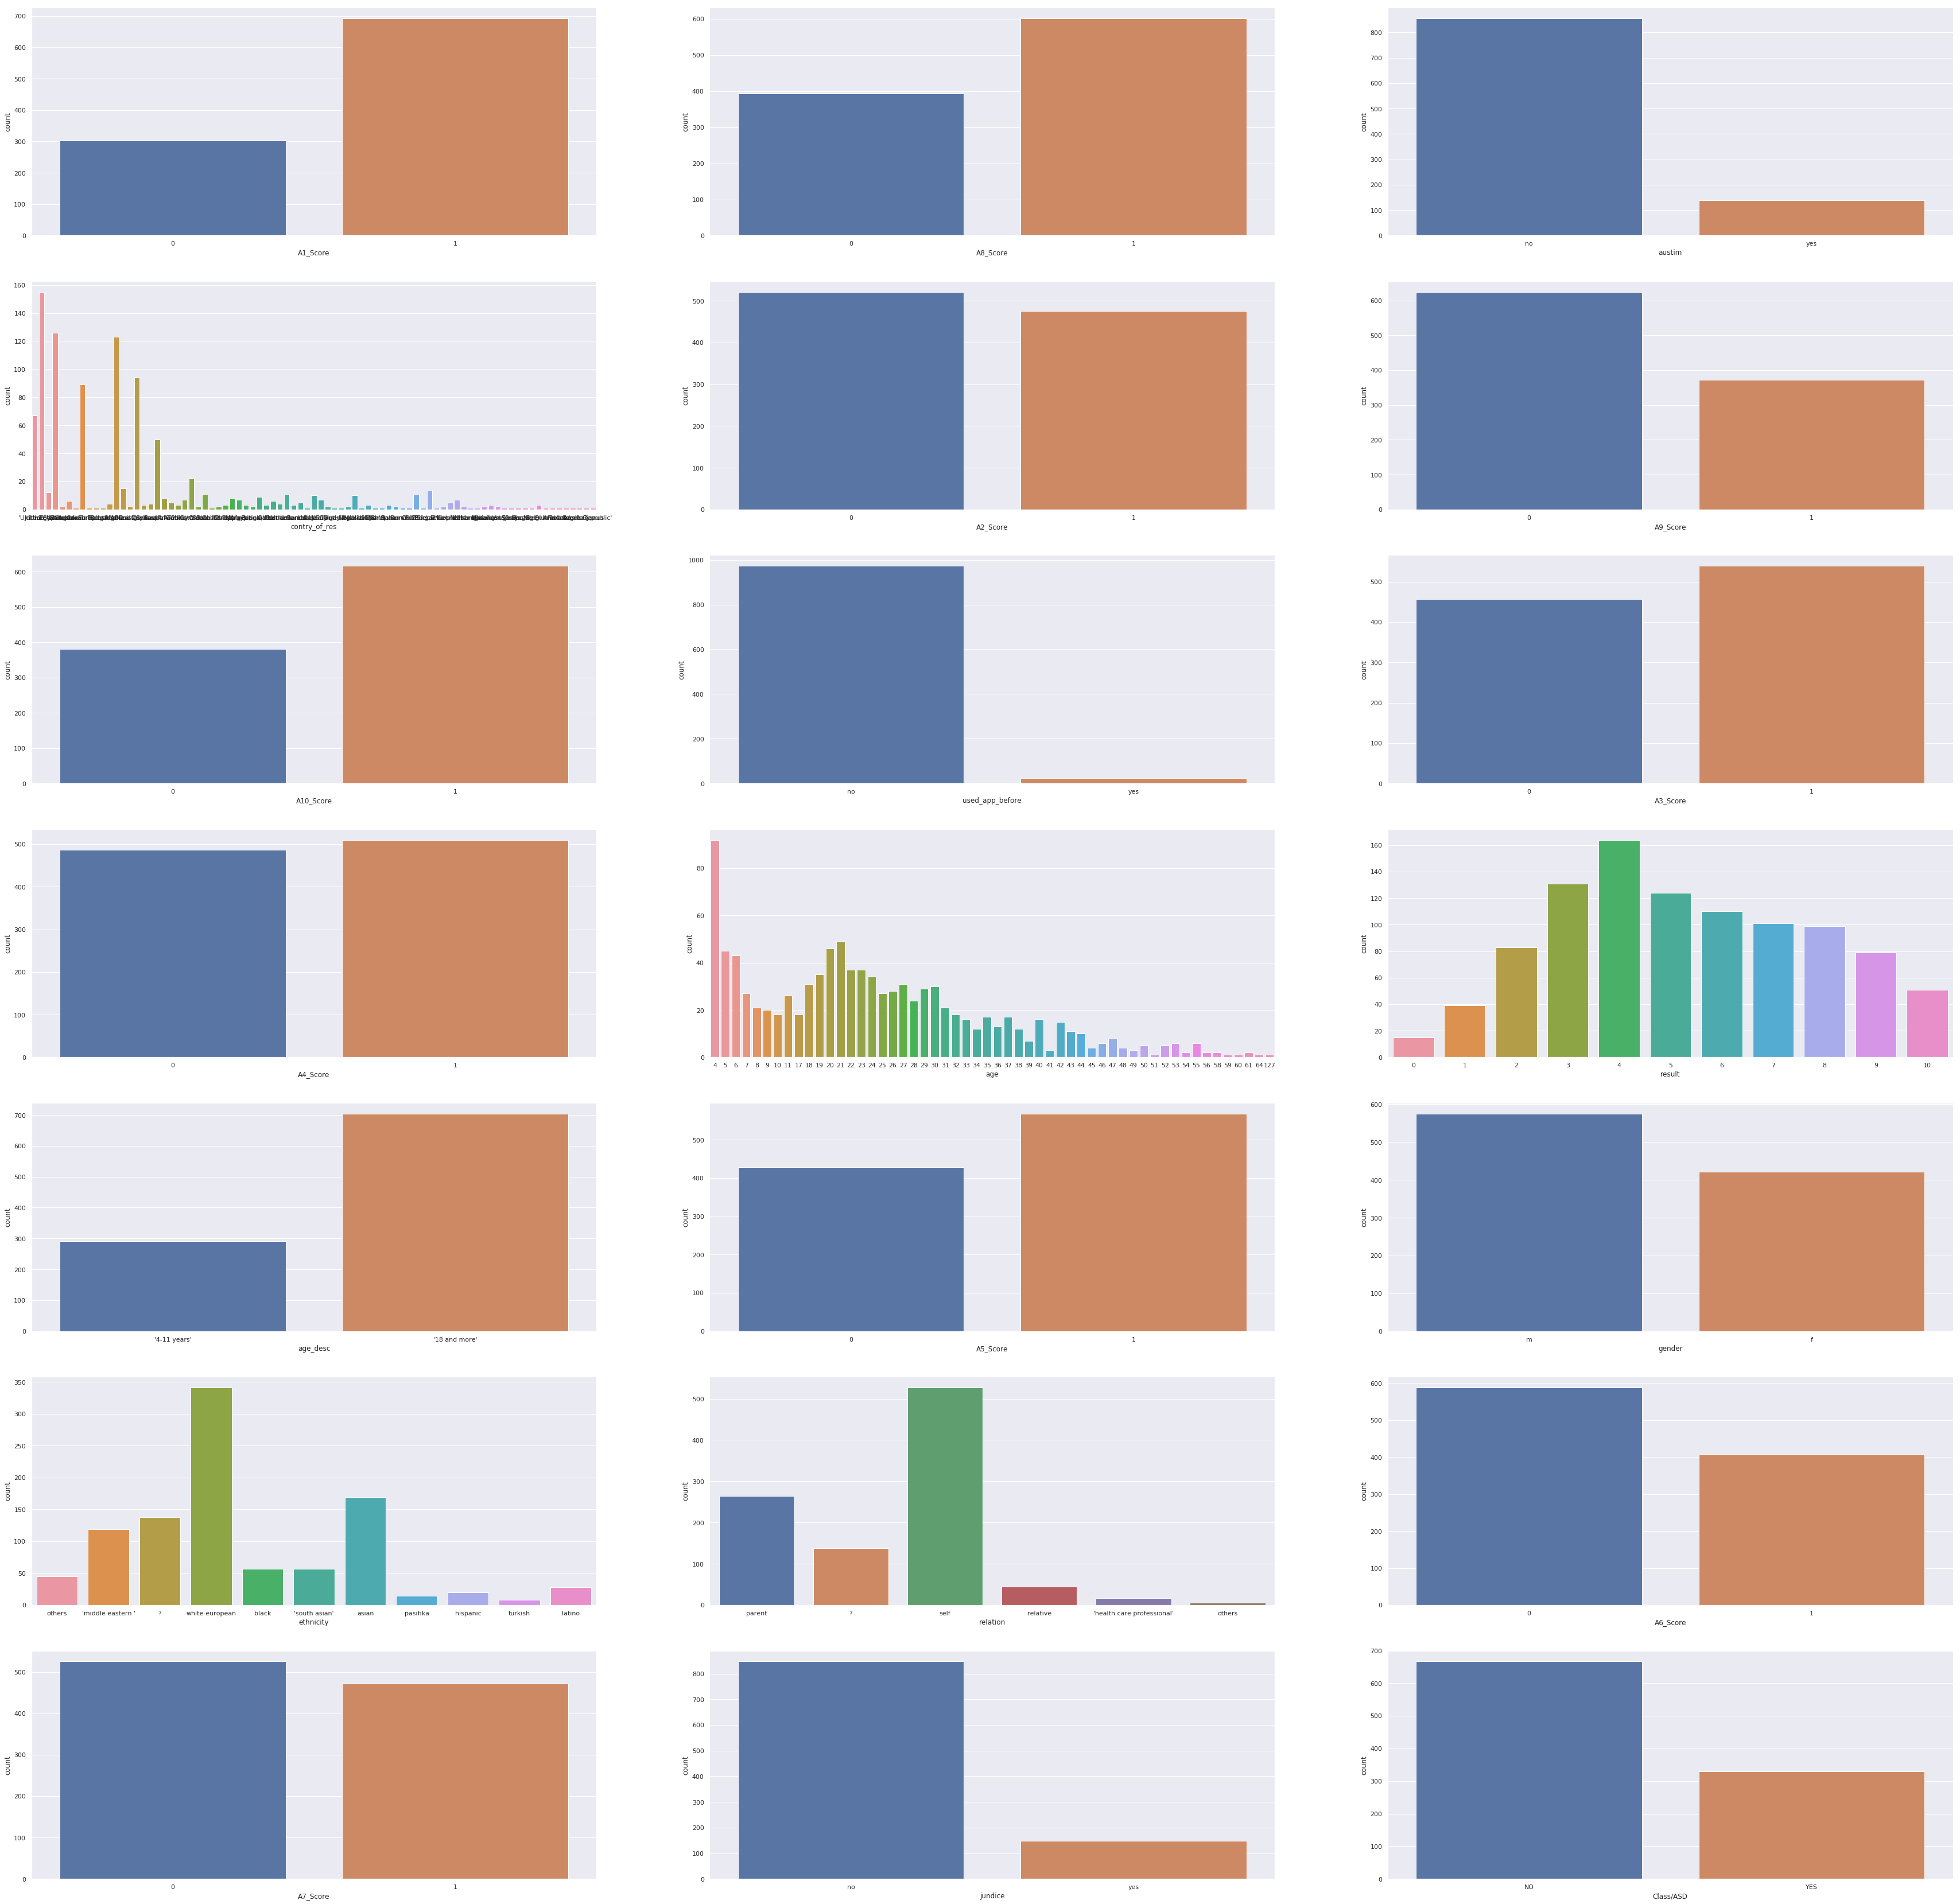

In [19]:
fig, axarr = plt.subplots(7, 3, figsize = (60, 60))


for i, column in enumerate(complete.columns):
    plt.sca(axarr[i % 7, i % 3])
    sns.countplot(x = column, data = complete)

plt.show()

Una criticità che emerge dal grafico è l'alto numero di diversi valori per la feature `contry_of_res`, usare un _one-hot-encoding_ in questo contesto potrebbe portare ad una esplosione del numero delle feature.

Si procede con contare il numero dei diversi valori che assumono le diverse feature.

In [20]:
for column in complete.columns:
    print('{}: {}'.format(column, len(set(complete[column]))))

A1_Score: 2
A2_Score: 2
A3_Score: 2
A4_Score: 2
A5_Score: 2
A6_Score: 2
A7_Score: 2
A8_Score: 2
A9_Score: 2
A10_Score: 2
age: 54
gender: 2
ethnicity: 11
jundice: 2
austim: 2
contry_of_res: 83
used_app_before: 2
result: 11
age_desc: 2
relation: 6
Class/ASD: 2


## Analisi ASD e Itterizia

Text(0.5, 0, 'Itterizzia alla nascita')

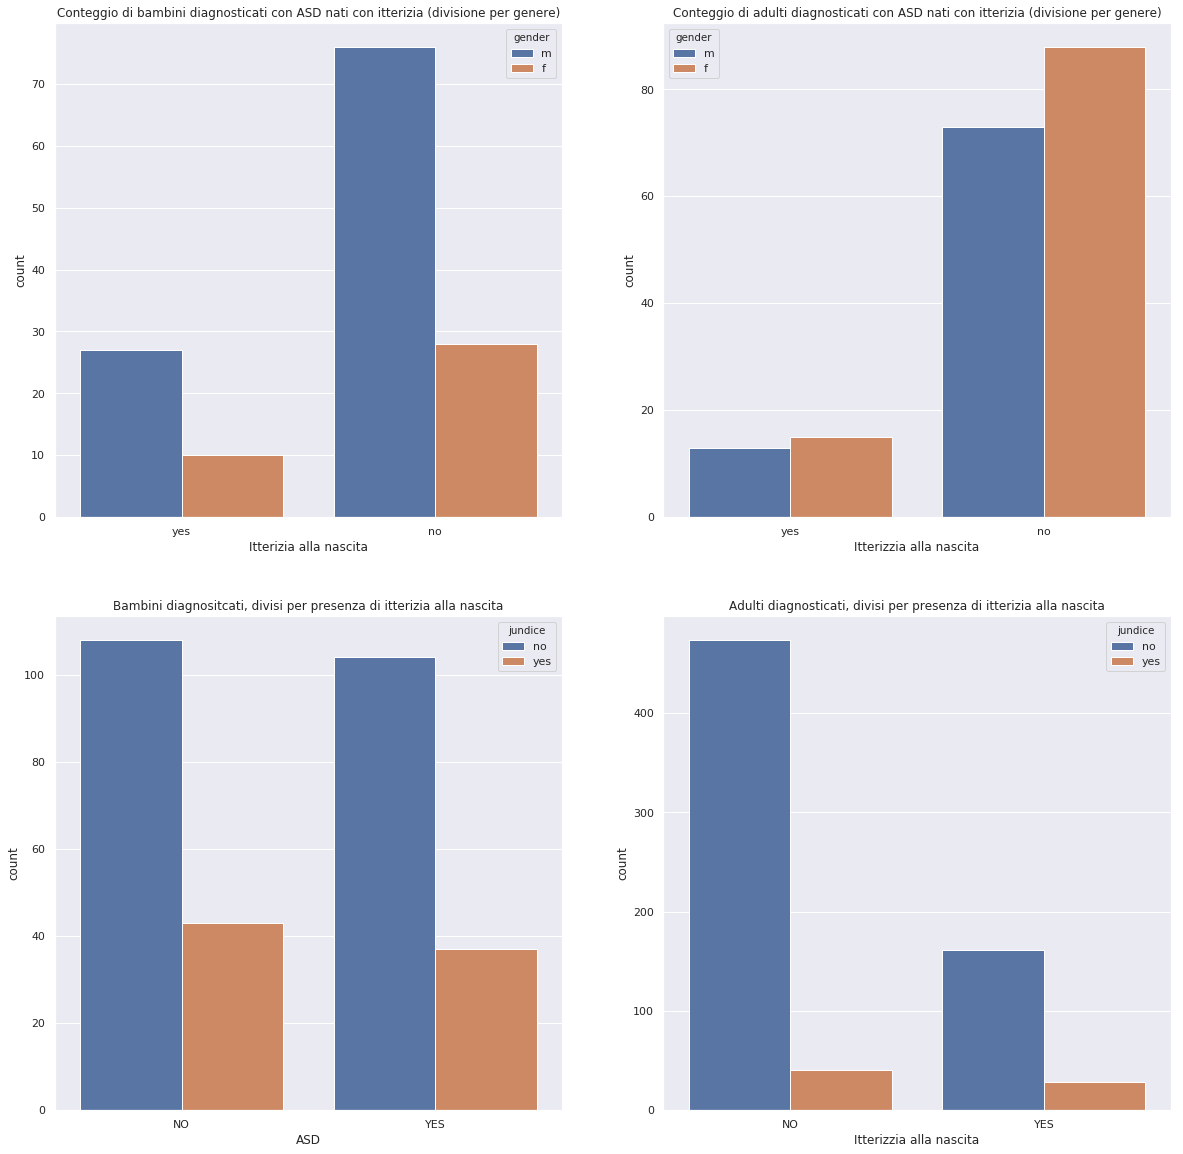

In [21]:
data1 = child[child['Class/ASD']=='YES']
data2 = adult[adult['Class/ASD']=='YES']

fig, ax = plt.subplots(2,2,figsize=(20,20))

sns.countplot(x='jundice',data=data1,hue='gender',ax=ax[0,0])
ax[0,0].set_title('Conteggio di bambini diagnosticati con ASD nati con itterizia (divisione per genere)')
ax[0,0].set_xlabel('Itterizia alla nascita')

sns.countplot(x='jundice',data=data2,hue='gender',ax=ax[0,1])
ax[0,1].set_title('Conteggio di adulti diagnosticati con ASD nati con itterizia (divisione per genere)')
ax[0,1].set_xlabel('Itterizzia alla nascita')

sns.countplot(x='Class/ASD',data=child,hue='jundice',ax=ax[1,0])
ax[1,0].set_title('Bambini diagnositcati, divisi per presenza di itterizia alla nascita')
ax[1,0].set_xlabel('ASD')

sns.countplot(x='Class/ASD',data=adult ,hue='jundice',ax=ax[1,1])
ax[1,1].set_title('Adulti diagnosticati, divisi per presenza di itterizia alla nascita')
ax[1,1].set_xlabel('Itterizzia alla nascita')

## Analisi ASD ed età

In [1]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.distplot(data1['age'],kde=False,bins=45,color='darkred',ax=ax[0])
ax[0].set_xlabel('Età bambini')
ax[0].set_title('Distribuzione delle diagnosi di ASD per età')

sns.distplot(data2['age'],kde=False,bins=60,color='darkred',ax=ax[1])
ax[1].set_xlabel('Età adulti')
ax[1].set_title('Distribuzione delle diagnosi di ASD per età')

NameError: name 'plt' is not defined

Dal grafico è possibile notare come le diagnosi di autismo nei bambini siano molto frequenti attorno ai 4 anni per poi più che dimmezzarsi per gli anni successivi.

Per quanto riguarda gli adulti è possibile notare come i soggetti maggiormente diagnosticati siano i ventenni e i trentenni

## Analisi a livello di entia e famigliare

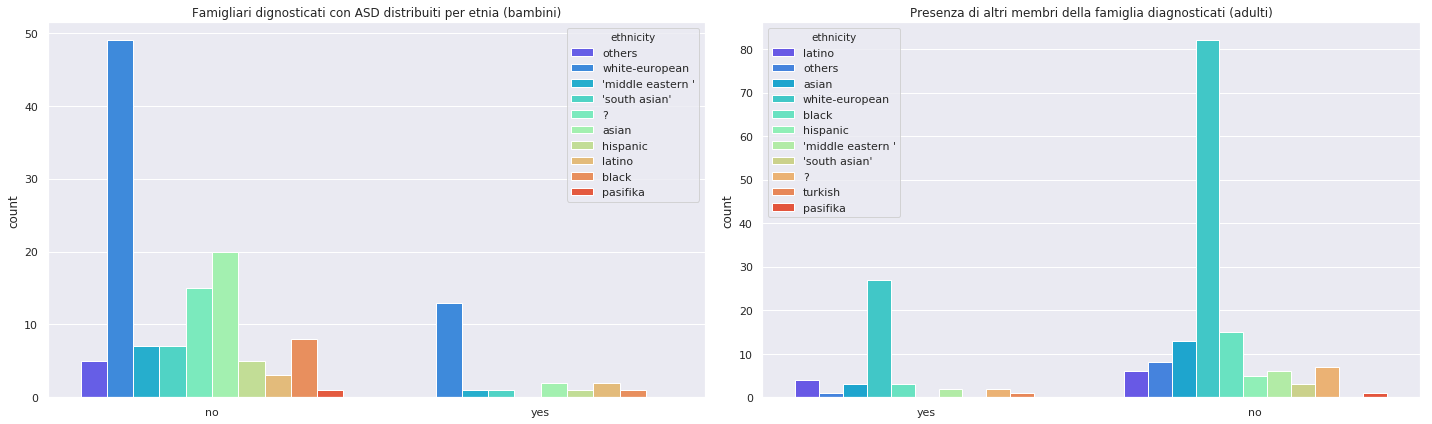

In [23]:
fig, ax = plt.subplots(1,2,figsize=(20,6))
sns.countplot(x='austim',data=data1,hue='ethnicity',palette='rainbow',ax=ax[0])
ax[0].set_title("Famigliari dignosticati con ASD distribuiti per etnia (bambini)")
ax[0].set_xlabel('')

sns.countplot(x='austim',data=data2,hue='ethnicity',palette='rainbow',ax=ax[1])
ax[1].set_title('Presenza di altri membri della famiglia diagnosticati (adulti)')
ax[1].set_xlabel('')
plt.tight_layout()

## Feature engeneering

Si decide di non sfruttare la feature che rappresenza la città di residenza data l'elevato numero di possibili valori che può assumere.
Dato che alcuni modelli, come catboost, possono gestire senza bisogno di encoding i dati categorici verranno effettuati di confronti per determinare se questa feature svolte un ruolo determinate o meno all'interno del modello.

In [24]:
child.drop('contry_of_res', inplace=True, axis = 1)
adult.drop('contry_of_res', inplace=True, axis = 1)
complete.drop('contry_of_res', inplace=True, axis = 1)

Prima di proseguire con le modifiche al dataset viene eseguita una copia del dataset compelto di partenza

In [25]:
complete_copy = complete.copy()

Per le altre feature vengono introdotte delle feature ottenute mediante `one_hot_encoding` per potere rappresentare i dati in modo numerico, queste operazioni vengono svolte su una copia del dataset compelto in modo da potere eseguire dei test sfruttando anche modelli basati su dati categorici.


In [26]:
male=pd.get_dummies(complete['gender'],drop_first=True)
ethnics=pd.get_dummies(complete['ethnicity'],drop_first=True)
jaundice=pd.get_dummies(complete['jundice'],drop_first=True)
ASD_genes=pd.get_dummies(complete['austim'],drop_first=True)
used_app_before = pd.get_dummies(complete['used_app_before'], drop_first=True)
relation = pd.get_dummies(complete['relation'], drop_first=True)
age_desc = pd.get_dummies(complete['age_desc'], drop_first=True)

encoded = pd.concat([male, ethnics, jaundice, ASD_genes, used_app_before, relation, age_desc], axis = 1)

In [27]:
set(male)

{'m'}

In [28]:
set(ethnics)

{"'south asian'",
 '?',
 'asian',
 'black',
 'hispanic',
 'latino',
 'others',
 'pasifika',
 'turkish',
 'white-european'}

In [29]:
set(jaundice)

{'yes'}

In [30]:
set(ASD_genes)

{'yes'}

In [31]:
set(used_app_before)

{'yes'}

In [32]:
set(relation)

{'?', 'others', 'parent', 'relative', 'self'}

In [33]:
set(age_desc)

{"'4-11 years'"}

In [34]:
encoded.sample()

,m,'south asian',?,asian,black,hispanic,latino,others,pasifika,turkish,white-european,yes,yes,yes,?,others,parent,relative,self,'4-11 years'
3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0


In [35]:
encoded.columns=['male','South Asian','?','Asian','Black','Hispanic','Latino','Others_ethnics','Pasifika','Tuekish','White-European','Jaundice','ASD_relatives', 'Used_app_before', 'relation_?', 'relation_other', 'relation_parent', 'relation_relative', 'relation_self', 'child']

In [36]:
complete.drop('gender', axis = 1, inplace=True)
complete.drop('ethnicity', axis = 1, inplace=True)
complete.drop('jundice', axis = 1, inplace=True)
complete.drop('austim', axis = 1, inplace=True)
complete.drop('used_app_before', axis = 1, inplace=True)
complete.drop('relation', axis = 1, inplace=True)
complete.drop('age_desc', axis = 1, inplace=True)

In [37]:
complete_concat = pd.concat([encoded, complete], axis = 1)

In [38]:
complete_concat.sample(10)

,male,South Asian,?,Asian,Black,Hispanic,Latino,Others_ethnics,Pasifika,Tuekish,...,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result,Class/ASD
398,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,26,3,NO
359,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,20,2,NO
680,1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,40,10,YES
275,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,0,26,4,NO
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,17,2,NO
654,1,0,0,1,0,0,0,0,0,0,...,1,1,0,1,1,1,1,30,9,YES
74,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,1,1,1,37,6,NO
586,1,0,0,0,1,0,0,0,0,0,...,1,1,1,1,1,1,1,21,10,YES
149,1,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,4,3,NO
457,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,30,1,NO


---

# Modellazione

In questa sezione verranno descritti a grandi linee i modelli adoperati e la natura del problema.

Il problema può essere affrontato come un problema di classificazione multivariata, verranno utilizzati vari modelli e risultati confrontati.

I modelli in esame saranno:

- random forest
- xgboost
- catboost
- SVM

## Aspetti teorici dei modelli

Vista la natura medica e sociale del problema affrontato ho preferito usare modelli piu' facilmente interpretabili rispetto alla reti neurali in modo che a posteriori si possano ottenere informazioni sulle feature che maggiormante hanno paetecipato alla "scoperta" dell'informazione

### Random forest

Le random forest sono un esempio di algoritmo di learning basato sulla tecnicva dell'ensable, un processo che consiste nell'unire le predizioni fornite da modelli "deboli" per avere una predizione maggiormante accurata, nel caso di radom forest i modelli che vengono assemblati sono degli alberi di decisione.

Lo scopo di una random foreset, come suggerisce il nome, e' introdurre dei gradi di casualita' all'interno del modello, nello specifico:

- ogni albero viene addestrato con un sottoinsieme casuale delle righe
- le feature indagate per eseguire uno split all'interno del nodo di un albero sono un subset casuale di tutte le feature a disposizione

Queste decisioni portano ad avere alberi molto diversi tra di loro essendo creati in modo completamente indipendente

Questo tipo di modello gestisce in modo efficace eventuali valori mancanti ed e' meno predisposto all'overfitting vista l'intrinseca casualita' che lo contraddistingue, di contro ,a causa dell'elevato numero di alberi che formano il modello, e' difficile applicare il modello a situazioni real-time.

### xgboost

XGBoost e' una implementazione di una tecnica chiamata _gradient boosting decision tree_, un approccio simile a quello usato da random forest ma in cui ogni albero viene addestrato in modo che sia capace di correggere gli errori compiuti dal suo predecessore.


### catboost

Catboost e' libreria basata sul concetto di gradient boosting prodotta da Yandex con lo scopo ottimizare predizioni in cui le variabili di tipo categorico prevalgono.

Adotta un approccio per il quale ogni valore delle feature categoriche viene sostituita con una statica legata al valore della label


### voting

Dopo avere addestrato i modelli elencati in precedenza verra' creato anche un modello basato sulla votazione all'interno del quale gli altri modelli saranno chiamati ad esprimere una votazione per determinare l'esito della classificazione



## Implementazione

Prima di tutto verra' effettuata una divisione in train e test set

In [39]:
train_size = 0.7

In [40]:
X_enc = complete_concat.drop(columns = ['Class/ASD'])
y_enc = complete_concat['Class/ASD']
y_enc = (y_enc == 'YES').astype('int8')

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, train_size = train_size, stratify = y_enc)

In [41]:
X = complete_copy.drop(columns=['Class/ASD'])
y = complete_concat['Class/ASD']
y = (y == 'YES').astype('int8')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size, stratify = y)

Questa divisione tra train e test rimarra' invariata nei confronti tra i vari modelli in modo che il confronto tra di essi non dipenda dai dati

# Test semplici (Encoding)

In questa sezione vengono creati ed addestrati dei modelli semplici (nessuna configurazione degli iperparametri) e messi a confronti i loro risultati

In [42]:
models = {}

In [43]:
rfc_enc = RandomForestClassifier(n_estimators = 10000)
rfc_enc.fit(X_train_enc, y_train_enc)
rfc_enc_pred = rfc_enc.predict(X_test_enc)
print(confusion_matrix(y_test_enc, rfc_enc_pred))
print(classification_report(y_test_enc,rfc_enc_pred))
models['random forest, ALL'] = rfc_enc

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [44]:
xgb_enc = XGBClassifier(n_estimators = 10000)
xgb_enc.fit(X_train_enc, y_train_enc)
xgb_enc_pred = rfc_enc.predict(X_test_enc)
print(confusion_matrix(y_test_enc, xgb_enc_pred))
print(classification_report(y_test_enc, xgb_enc_pred))
models['xgb, ALL'] = xgb_enc

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [45]:
cat_enc = CatBoostClassifier()
cat_enc.fit(X_train_enc, y_train_enc, verbose = False)
cat_enc_pred = rfc_enc.predict(X_test_enc)
print(confusion_matrix(y_test_enc, cat_enc_pred))
print(classification_report(y_test_enc, cat_enc_pred))
models['cat, standard'] = cat_enc

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [46]:
for i, column in enumerate(X_train.columns):
    print('{}: {}'.format(i, column))

0: A1_Score
1: A2_Score
2: A3_Score
3: A4_Score
4: A5_Score
5: A6_Score
6: A7_Score
7: A8_Score
8: A9_Score
9: A10_Score
10: age
11: gender
12: ethnicity
13: jundice
14: austim
15: used_app_before
16: result
17: age_desc
18: relation


In [47]:
cat_column_index = [11, 12, 13, 14, 15,15, 17, 18]

In [48]:
cat = CatBoostClassifier(cat_features=cat_column_index)
cat.fit(X_train, y_train, verbose = False)
cat_pred = cat.predict(X_test)
print(confusion_matrix(y_test, cat_pred))
print(classification_report(y_test, cat_pred))
models['cat, categories'] = cat

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



Osservando il report dei vari modelli di bas è possibile notare come `CatBoost` si comporti in maniera perfetta mentre gli altri modelli si fermano al 65% di accuratezza per la classe 1 (malati) e solamente al 30% per la classe 0 (sani)

In [49]:
svm_enc = SVC()
svm_enc.fit(X_train_enc, y_train_enc)
svm_env_pred = svm_enc.predict(X_test_enc)
print(confusion_matrix(y_test_enc, svm_env_pred))
print(classification_report(y_test_enc, svm_env_pred))
models['svm, ALL'] = svm_enc

[[200   0]
 [  3  96]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       200
           1       1.00      0.97      0.98        99

    accuracy                           0.99       299
   macro avg       0.99      0.98      0.99       299
weighted avg       0.99      0.99      0.99       299



/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


---

# Interpretazione dei risultati

Per verificare cosa i modeli abbiano appreso si utilizza la libreria [shap](https://github.com/slundberg/shap)

https://www.nature.com/articles/s41551-018-0304-0

## Random forest cl

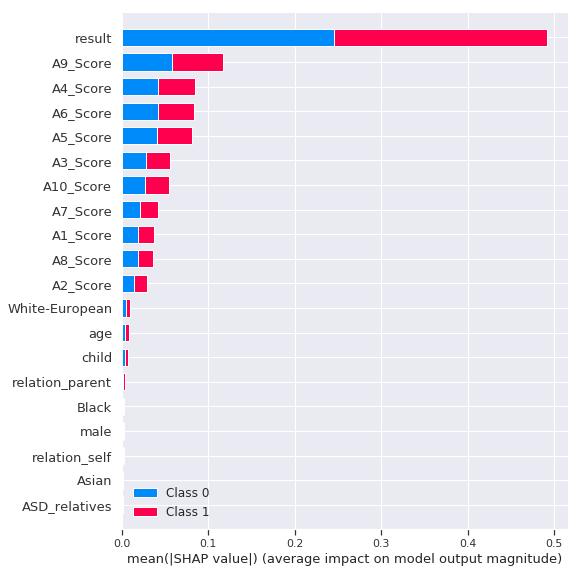

In [50]:
explainer = shap.TreeExplainer(rfc_enc)
shap_values = explainer.shap_values(X_enc)
shap.summary_plot(shap_values, X_enc, plot_type='bar')

## Xgboost

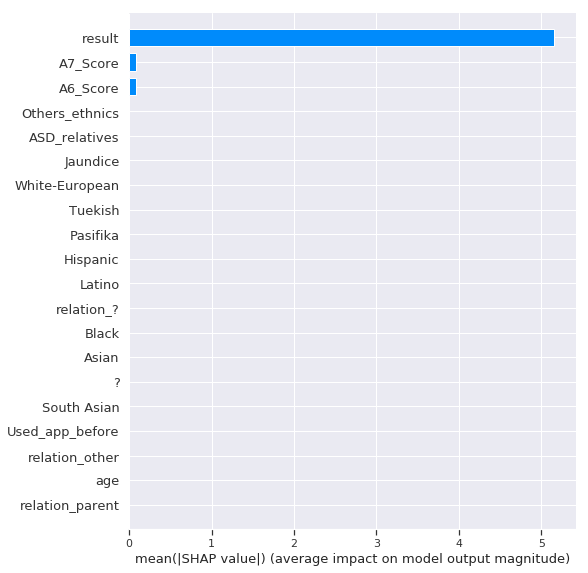

In [51]:
explainer = shap.TreeExplainer(xgb_enc)
shap_values = explainer.shap_values(X_enc)
shap.summary_plot(shap_values, X_enc, plot_type='bar')

## Catboost (con variabili encodate)

/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


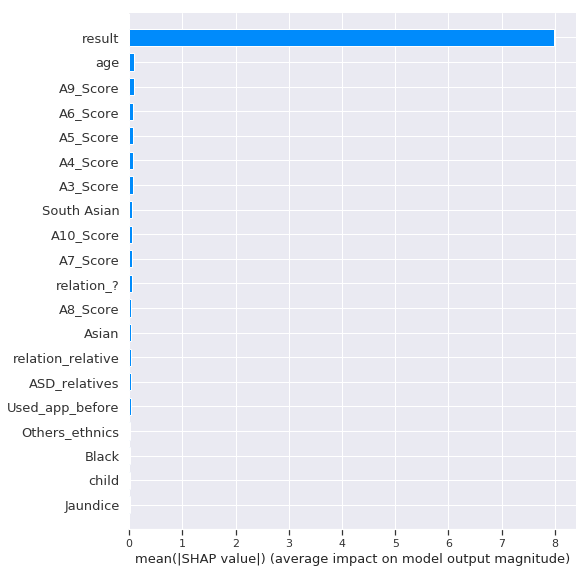

In [52]:
explainer = shap.TreeExplainer(cat_enc)
shap_values = explainer.shap_values(X_enc)
shap.summary_plot(shap_values, X_enc, plot_type='bar')

dai grafici è possibile evincere che la feature di maggiore importanza è `result`, ovvero il numero di risposte affermative date.
Occorre indagare se effettivamente i vari parametri sono poco importanti oppure se la presenza di una variabile dipendente dalle altre (result), porti a predizioni "inquinate" 

Si decide di effetture ulteriori test:

- escludere l'etnia perche' offuscata
- escludere result perche' predominante
- escludere result ed etnia

---

# Test foresete senza etnia

In [53]:
models_noEtn = []

In [54]:
X_enc_noEtn = X_enc.drop(['South Asian','?','Asian','Black','Hispanic','Latino','Others_ethnics','Pasifika','Tuekish','White-European'], axis = 1)
X_train_enc_noEtn = X_train_enc.drop(['South Asian','?','Asian','Black','Hispanic','Latino','Others_ethnics','Pasifika','Tuekish','White-European'], axis = 1)
X_test_enc_noEtn =  X_test_enc.drop(['South Asian','?','Asian','Black','Hispanic','Latino','Others_ethnics','Pasifika','Tuekish','White-European'], axis = 1)

In [55]:
print(X_train_enc_noEtn.shape)
print(X_test_enc_noEtn.shape)

(697, 22)
(299, 22)


## random forest

In [56]:
rfc_enc_noEtn = RandomForestClassifier(n_estimators=10000)
rfc_enc_noEtn.fit(X_train_enc_noEtn, y_train_enc)
rfc_enc_noEtn_pred = rfc_enc_noEtn.predict(X_test_enc_noEtn)
print(confusion_matrix(y_test_enc, rfc_enc_noEtn_pred))
print(classification_report(y_test_enc,rfc_enc_noEtn_pred))

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [57]:
models_noEtn.append(('random forest',rfc_enc_noEtn))

In [58]:
models_noEtn

[('random forest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10000,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False))]

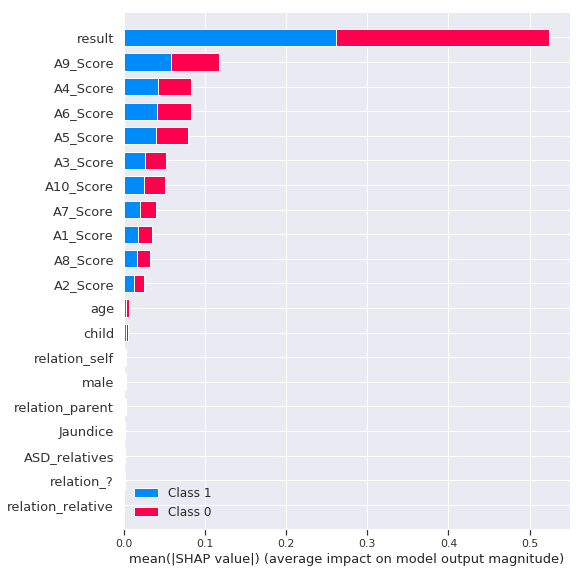

In [59]:
explainer = shap.TreeExplainer(rfc_enc_noEtn)
shap_values = explainer.shap_values(X_enc_noEtn)
shap.summary_plot(shap_values, X_enc_noEtn, plot_type='bar')

## XGBoost

In [60]:
xgb_enc_noEtn = XGBClassifier(n_estimators=10000)
xgb_enc_noEtn.fit(X_train_enc_noEtn, y_train_enc)
xgb_enc_noEtn_pred = xgb_enc_noEtn.predict(X_test_enc_noEtn)
print(confusion_matrix(y_test_enc, xgb_enc_noEtn_pred))
print(classification_report(y_test_enc,xgb_enc_noEtn_pred))

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [61]:
models_noEtn.append(('xgb', xgb_enc_noEtn))

In [62]:
models_noEtn

[('random forest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10000,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False)),
 ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=True, subsample=1))]

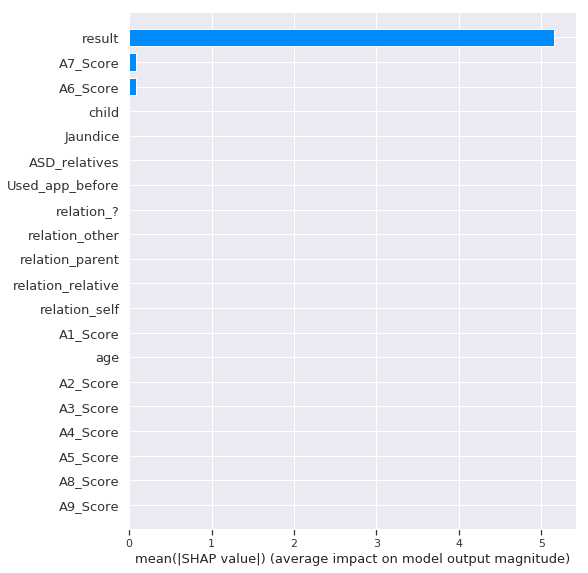

In [63]:
explainer = shap.TreeExplainer(xgb_enc_noEtn)
shap_values = explainer.shap_values(X_enc_noEtn)
shap.summary_plot(shap_values, X_enc_noEtn, plot_type='bar')

## Catboost encoded

In [64]:
cat_enc_noEtn = CatBoostClassifier(n_estimators=10000)
cat_enc_noEtn.fit(X_train_enc_noEtn, y_train_enc, silent = True)
cat_enc_noEtn_pred = cat_enc_noEtn.predict(X_test_enc_noEtn)
print(confusion_matrix(y_test_enc, cat_enc_noEtn_pred))
print(classification_report(y_test_enc,xgb_enc_noEtn_pred))

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



In [65]:
models_noEtn.append(('catboost', CatBoostClassifierCorrected(n_estimators = 10000)))

In [66]:
models_noEtn

[('random forest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                         max_depth=None, max_features='auto', max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10000,
                         n_jobs=None, oob_score=False, random_state=None,
                         verbose=0, warm_start=False)),
 ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=True, subsample=1)),
 ('catboost', <__main__.CatBoostClassifierCorrected at 0x7fcc845eb7f0>)]

/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


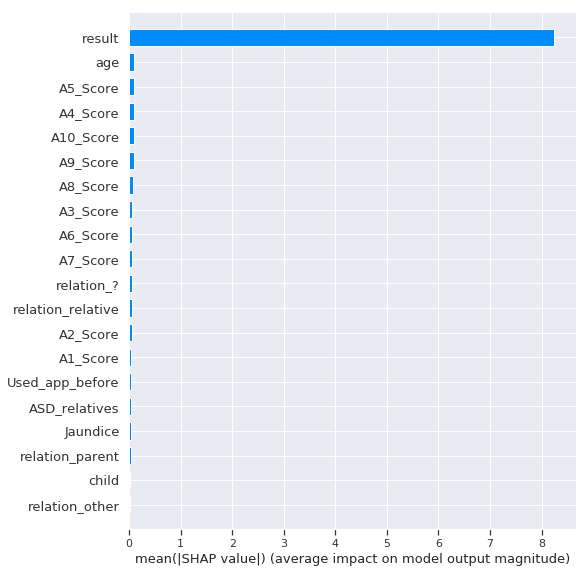

In [67]:
explainer = shap.TreeExplainer(cat_enc_noEtn)
shap_values = explainer.shap_values(X_enc_noEtn)
shap.summary_plot(shap_values, X_enc_noEtn, plot_type='bar')

## Catboost category

In [68]:
X_noEtn = X.drop(['ethnicity'], axis = 1)
X_train_noEtn = X_train.drop(['ethnicity'], axis = 1)
X_test_noEtn = X_test.drop(['ethnicity'], axis = 1)

In [69]:
for i, column in enumerate(X_train_noEtn.columns):
    print('{}: {} is {}'.format(i, column, X_train_noEtn.dtypes[i]))

0: A1_Score is int8
1: A2_Score is int8
2: A3_Score is int8
3: A4_Score is int8
4: A5_Score is int8
5: A6_Score is int8
6: A7_Score is int8
7: A8_Score is int8
8: A9_Score is int8
9: A10_Score is int8
10: age is int8
11: gender is object
12: jundice is object
13: austim is object
14: used_app_before is object
15: result is int8
16: age_desc is object
17: relation is object


In [70]:
list_category_noEtn = [11, 12, 13, 14, 16, 17]

In [71]:
cat_noEtn = CatBoostClassifier(cat_features=list_category_noEtn)
cat_noEtn.fit(X_train_noEtn, y_train, verbose = False)
cat_pred_noEtn = cat_noEtn.predict(X_test_noEtn)
print(confusion_matrix(y_test, cat_pred_noEtn))
print(classification_report(y_test, cat_pred_noEtn))

[[200   0]
 [  0  99]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      1.00      1.00        99

    accuracy                           1.00       299
   macro avg       1.00      1.00      1.00       299
weighted avg       1.00      1.00      1.00       299



---

# Test senza result

In [72]:
models_noRes = []

Si riscontra una leggero miglioramento nel modello, si procede con eliminare anche result vista la sua predominanza assoluta nel modello

In [73]:
X_enc_noRes = X_enc.drop(['result'], axis = 1)
X_train_enc_noRes = X_train_enc.drop(['result'], axis = 1)
X_test_enc_noRes = X_test_enc.drop(['result'], axis = 1)

## random forest

In [74]:
rfc_enc_noRes = RandomForestClassifier(n_estimators=10000)
rfc_enc_noRes.fit(X_train_enc_noRes, y_train_enc)
rfc_enc_noRes_pred = rfc_enc_noRes.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, rfc_enc_noRes_pred))
print(classification_report(y_test_enc,rfc_enc_noRes_pred))

[[198   2]
 [ 15  84]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       200
           1       0.98      0.85      0.91        99

    accuracy                           0.94       299
   macro avg       0.95      0.92      0.93       299
weighted avg       0.95      0.94      0.94       299



In [75]:
models_noRes.append(('random forest', rfc_enc_noRes))

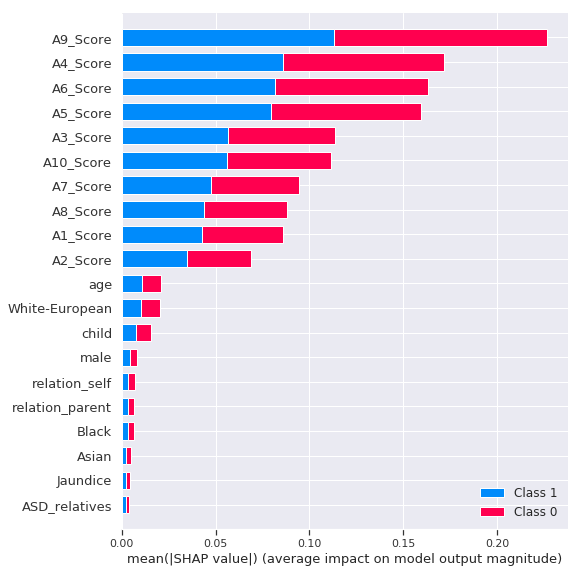

In [76]:
explainer = shap.TreeExplainer(rfc_enc_noRes)
shap_values = explainer.shap_values(X_enc_noRes)
shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

## xgboost

In [77]:
xgb_enc_noRes = XGBClassifier(n_estimators=10000)
xgb_enc_noRes.fit(X_train_enc_noRes, y_train_enc)
xgb_enc_noRes_pred = xgb_enc_noRes.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, xgb_enc_noRes_pred))
print(classification_report(y_test_enc,xgb_enc_noRes_pred))

[[195   5]
 [  4  95]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.95      0.96      0.95        99

    accuracy                           0.97       299
   macro avg       0.96      0.97      0.97       299
weighted avg       0.97      0.97      0.97       299



In [78]:
models_noRes.append(('xgboost', xgb_enc_noRes))

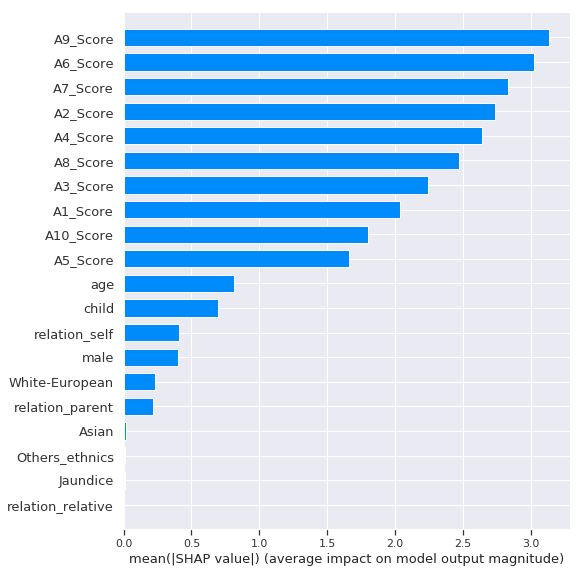

In [79]:
explainer = shap.TreeExplainer(xgb_enc_noRes)
shap_values = explainer.shap_values(X_enc_noRes)
shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

## Catboost encoded

In [80]:
cat_enc_noRes = CatBoostClassifier(n_estimators=10000)
cat_enc_noRes.fit(X_train_enc_noRes, y_train_enc, silent = True)
cat_enc_noRes_pred = cat_enc_noRes.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, cat_enc_noRes_pred))
print(classification_report(y_test_enc,xgb_enc_noRes_pred))

[[200   0]
 [  6  93]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       200
           1       0.95      0.96      0.95        99

    accuracy                           0.97       299
   macro avg       0.96      0.97      0.97       299
weighted avg       0.97      0.97      0.97       299



In [81]:
models_noRes.append(('catboost', CatBoostClassifierCorrected(n_estimators = 10000)))

/home/montelli/.conda/envs/montelli_python/lib/python3.7/site-packages/catboost/core.py:1697: UserWarning: 'fstr_type' parameter will be deprecated soon, use 'type' parameter instead
  warnings.warn("'fstr_type' parameter will be deprecated soon, use 'type' parameter instead")


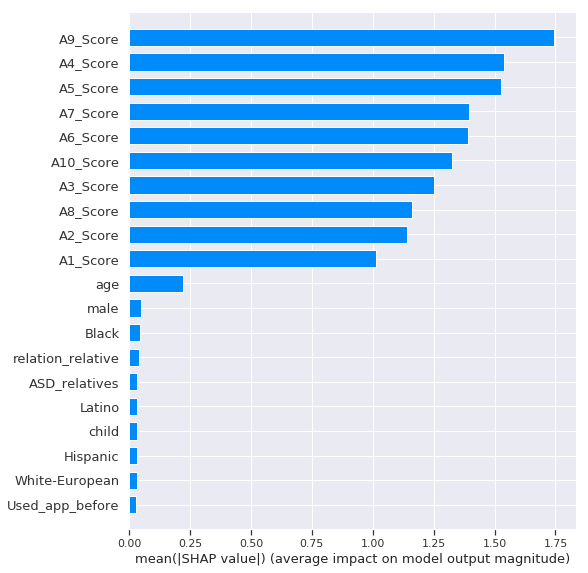

In [82]:
explainer = shap.TreeExplainer(cat_enc_noRes)
shap_values = explainer.shap_values(X_enc_noRes)
shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

## Catboost

In [83]:
X_noRes = X.drop(['result'], axis = 1)
X_train_noRes = X_train.drop(['result'], axis = 1)
X_test_noRes = X_test.drop(['result'], axis = 1)

In [84]:
for i, column in enumerate(X_train_noRes.columns):
    print('{}: {} is {}'.format(i, column, X_train_noRes.dtypes[i]))

0: A1_Score is int8
1: A2_Score is int8
2: A3_Score is int8
3: A4_Score is int8
4: A5_Score is int8
5: A6_Score is int8
6: A7_Score is int8
7: A8_Score is int8
8: A9_Score is int8
9: A10_Score is int8
10: age is int8
11: gender is object
12: ethnicity is object
13: jundice is object
14: austim is object
15: used_app_before is object
16: age_desc is object
17: relation is object


In [85]:
list_categoric_noRes = [11, 12, 13, 14, 15, 16, 17]

In [86]:
cat_noRes = CatBoostClassifier(n_estimators=10000, cat_features=list_categoric_noRes)
cat_noRes.fit(X_train_noRes, y_train, verbose = False)
cat_pred_noRes = cat_noRes.predict(X_test_noRes)
print(confusion_matrix(y_test, cat_pred_noRes))
print(classification_report(y_test, cat_pred_noRes))

[[200   0]
 [  6  93]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       200
           1       1.00      0.94      0.97        99

    accuracy                           0.98       299
   macro avg       0.99      0.97      0.98       299
weighted avg       0.98      0.98      0.98       299



# Test senza etnia e senza result

In [87]:
models_noResEtn = []

In [88]:
X_enc_noResEtn = X_enc_noEtn.drop(['result'], axis = 1)
X_train_enc_noResEtn = X_train_enc_noEtn.drop(['result'], axis = 1)
X_test_enc_noResEtn = X_test_enc_noEtn.drop(['result'], axis = 1)

## random forest

In [89]:
rfc_enc_noResEtn = RandomForestClassifier(n_estimators=10000)
rfc_enc_noResEtn.fit(X_train_enc_nores, y_train_enc)
rfc_enc_noResEtn_pred = rfc_enc_noResEtn.predict(X_test_enc_noRes)
print(confusion_matrix(y_test_enc, rfc_enc_pred))
print(classification_report(y_test_enc,rfc_enc_pred))

NameError: name 'X_train_enc_nores' is not defined

In [ ]:
models_noResEtn.append(('random forest', rfc_enc_noResEtn))

In [ ]:
explainer = shap.TreeExplainer(rfc_enc_noRes)
shap_values = explainer.shap_values(X_enc_noRes)
shap.summary_plot(shap_values, X_enc_noRes, plot_type='bar')

## xgboost

In [ ]:
xgb_enc_noResEtn = XGBClassifier(n_estimators=10000)
xgb_enc_noResEtn.fit(X_train_enc_noResEtn, y_train_enc)
xgb_enc_noResEtn_pred = xgb_enc_noResEtn.predict(X_test_enc_noResEtn)
print(confusion_matrix(y_test_enc, xgb_enc_noResEtn_pred))
print(classification_report(y_test_enc,xgb_enc_noResEtn_pred))

In [ ]:
models_noResEtn.append(('xgboost', xgb_enc_noResEtn))

In [ ]:
explainer = shap.TreeExplainer(xgb_enc_noResEtn)
shap_values = explainer.shap_values(X_enc_noResEtn)
shap.summary_plot(shap_values, X_enc_noResEtn, plot_type='bar')

## catboost encoded

In [ ]:
cat_enc_noResEtn = CatBoostClassifier(n_estimators=10000)
cat_enc_noResEtn.fit(X_train_enc_noResEtn, y_train_enc, silent = True)
cat_enc_noResEtn_pred = cat_enc_noResEtn.predict(X_test_enc_noResEtn)
print(confusion_matrix(y_test_enc, cat_enc_noResEtn_pred))
print(classification_report(y_test_enc,cat_enc_noResEtn_pred))

In [ ]:
models_noResEtn.append(('catboost', CatBoostClassifierCorrected(n_estimators = 10000)))

In [ ]:
explainer = shap.TreeExplainer(cat_enc_noResEtn)
shap_values = explainer.shap_values(X_enc_noResEtn)
shap.summary_plot(shap_values, X_enc_noResEtn, plot_type='bar')

## Catboost

In [ ]:
X_noResEtn = X_noEtn.drop(['result'], axis = 1)
X_train_noResEtn = X_train_noEtn.drop(['result'], axis = 1)
X_test_noResEtn = X_test_noEtn.drop(['result'], axis = 1)

In [ ]:
for i, column in enumerate(X_train_noResEtn.columns):
    print('{}: {} is {}'.format(i, column, X_train_noResEtn.dtypes[i]))

In [ ]:
cat_list_noResEtn = list(range(11, 17))

In [ ]:
cat_list_noResEtn

In [ ]:
cat_noResEtn = CatBoostClassifier(n_estimators=10000, cat_features=cat_list_noResEtn)
cat_noResEtn.fit(X_train_noResEtn, y_train, silent = True)
cat_noResEtn_pred = cat_noResEtn.predict(X_test_noResEtn)
print(confusion_matrix(y_test, cat_noResEtn_pred))
print(classification_report(y_test,cat_noResEtn_pred))

---

Dopo le varie analisi senza incoudere `result` tra le feature sono emersi dei modelli in grado di predire con una ottima precisione entrambe le classi, per alzare ulteriormente questo livello si decide di combinarli in un unico classificatore basato sulla votazione in modo da avere risultati piu' accurati.

# Voting

Dopo avere trovato variati di modello piu' "stabili", si procede ad unire le predizioni dei vari modelli tramite un voting classifier e relative valutazioni mediate cross fold validation

In [ ]:
voting_noRes = VotingClassifier(estimators=models_noRes, n_jobs = -1)

In [ ]:
models_noRes

In [ ]:
voting_noEtn = VotingClassifier(models_noEtn, n_jobs = -1, voting='soft')

In [ ]:
models_noEtn

In [ ]:
voting_noResEtn = VotingClassifier(models_noResEtn, n_jobs = 1, voting = 'soft')

In [ ]:
models_noResEtn

In [ ]:
scores_noRes = cross_val_score(voting_noRes, X_enc_noRes.values, y.values, n_jobs = -1, cv = 3, verbose=True)

In [ ]:
score_noEtn = cross_val_score(voting_noEtn, X_enc_noEtn.values, y.values, cv = 5, verbose = True, n_jobs = -1)

In [ ]:
score_noResEtn = cross_val_score(voting_noResEtn, X_enc_noResEtn.values, y.values cv = 5, verbose = True, n_jobs = -1)

---

# Ricerca degli iperparametri

Dopo avere determinato quali sono i modelli migliori e' possibile applicare tecniche cone la grid search per ricercare gli iperparametri.

La grid search e' una tecnica che consiste nell'automatizzare la ricerca degli iperparametri migliori tramite una ricerca esaustiva della combinazione migliore secondo una metrica indicata, la valutazione avvieme mediate crossfold validation; per risparmiare tempo e' possibile procedere cona una ricerca randomica delle possibili combinazioni; in questo caso solo una sottoparte delle combinazioni verra' esamita.

Dopo avere eseguito la ricerca e' possibile estrarre i parametri migliori per creare poi un nuovo modello.

Dato che molti modelli hanno ottenuto risultati perfetti sfruttando i parametri standard la ricerca prosegue solamente sui modelli che non sono perfetti ma che presentano comunque buoni risultati.

## ricerca degli iperparametri negli alberi

Nonostante gli algoritmi usati siano abbastanza eterogei sono per la maggiorparte basati su foreste, per questo gli iperparametri da considerare sono circa gli stessi:

- numero di estimatori
- max_depth: profondita' massima degli alberi della foresta, al crescre di questo valore aumentano gli split che possono essere fatti e di conseguenza le informazioni che possono essere apprese
- min_samples_split: numero minimo di rappresentanti necessari per eseguire lo split di un nodo, se viene aumentato la rete ha limiti piu' stringenti durante la fase di apprendimento
- min_samples_leaf: numero di rappresentati minimi per potere considerare il nodo come foglia
- max_feature: numero di feature da considerare quando si cerca lo split